In [124]:
import torch 
import matplotlib.pyplot as plt


In [125]:
with open("data/names.txt") as f:
    words = f.read().splitlines()

chars = ["."] + sorted(list(set(''.join(words))))
vocab_size = len(chars) # 27 in this case

str_to_int = {s: i for i, s in enumerate(chars)}
int_to_str = {i: s for s, i in str_to_int.items()}


In [126]:
# Generate padded dataset (padded with '.')
context_length = 10

X = []
Y = []

print(min(len(w) for w in words))

for word in words:
    context = [0] * context_length
    for character in word + ".":
        token = str_to_int[character]
        X.append(context)
        Y.append(token)
        context = context[1:] + [token]


# for x, y in zip(X, Y):
#     name = "".join(int_to_str[i] for i in x)
#     y = int_to_str[y]
#     print(name, '------>', y)


X = torch.tensor(X)
Y = torch.tensor(Y)
print(X.shape)
print(Y.shape)

2
torch.Size([228146, 10])
torch.Size([228146])


In [127]:
from torch.utils.data import TensorDataset, DataLoader, random_split

dataset = TensorDataset(X, Y)
train_ds, test_val_ds = random_split(dataset, [0.8, 0.2])
val_ds, test_ds = random_split(test_val_ds, [0.5, 0.5])

batch_size = 1024
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=True)

In [128]:
from torch import nn
import torch.nn.functional as F
from tqdm import tqdm

In [146]:
class NeuralNet(nn.Module):
    def __init__(self, embedding_size=20):
        super().__init__()
        self.character_embeddings = nn.Embedding(vocab_size, embedding_size)
        self.input_size = context_length * embedding_size
        self.layers = nn.Sequential(
            nn.Linear(self.input_size, 1000),
            nn.BatchNorm1d(1000),
            nn.LeakyReLU(),
            nn.Linear(1000, 500),
            nn.BatchNorm1d(500),
            nn.LeakyReLU(),
            nn.Linear(500, vocab_size)
        )

    def forward(self, x):
        embeddings = self.character_embeddings(x)
        inpt = embeddings.view(-1, self.input_size)
        return self.layers(inpt)


model = NeuralNet().cuda()
optim = torch.optim.Adam(model.parameters(), lr=0.01)

global_loss = []

for epoch in range(7):

    train_losses = []
    val_losses = []

    with tqdm(train_dl) as dataloader:
        model.train()
        for x, y in dataloader:
            
            x, y = x.cuda(), y.cuda()
            logits = model(x)
            loss = F.cross_entropy(logits, y)

            train_losses.append(loss.item())

            optim.zero_grad()
            loss.backward()
            optim.step()
    
    with torch.no_grad():
        model.eval()
        for x, y in val_dl:
            x, y = x.cuda(), y.cuda()
            logits = model(x)
            loss = F.cross_entropy(logits, y)
            val_losses.append(loss.item())
        
    av_train_loss = sum(train_losses)/len(train_losses)
    av_val_loss = sum(val_losses)/len(val_losses)

    global_loss.append(av_train_loss)

    print(f"Epoch --> {epoch}\ntrain loss: {av_train_loss:.4f}\nval loss: {av_val_loss:.4f}\n")

100%|██████████| 179/179 [00:02<00:00, 81.67it/s]


Epoch --> 0
train loss: 2.2785
val loss: 2.1478



100%|██████████| 179/179 [00:02<00:00, 83.35it/s]


Epoch --> 1
train loss: 2.0770
val loss: 2.0866



100%|██████████| 179/179 [00:02<00:00, 87.64it/s]


Epoch --> 2
train loss: 2.0021
val loss: 2.0400



100%|██████████| 179/179 [00:02<00:00, 83.39it/s]


Epoch --> 3
train loss: 1.9450
val loss: 2.0228



100%|██████████| 179/179 [00:02<00:00, 85.04it/s]


Epoch --> 4
train loss: 1.9003
val loss: 2.0157



100%|██████████| 179/179 [00:02<00:00, 85.46it/s]


Epoch --> 5
train loss: 1.8601
val loss: 2.0045



100%|██████████| 179/179 [00:02<00:00, 88.43it/s]


Epoch --> 6
train loss: 1.8269
val loss: 2.0056



In [161]:
def evaluate_model(dataset):
    model.eval()
    losses = []
    for X, Y in dataset:
        X, Y = X.cuda(), Y.cuda()

        logits = model(X)
        loss = F.cross_entropy(logits, Y)
        losses.append(loss.item())
    
    print(sum(losses)/len(losses))


evaluate_model(train_dl)
evaluate_model(val_dl)
evaluate_model(test_dl)

        

1.7546717081656003
2.001994464708411
1.9795757739440254


Text(0, 0.5, 'Loss')

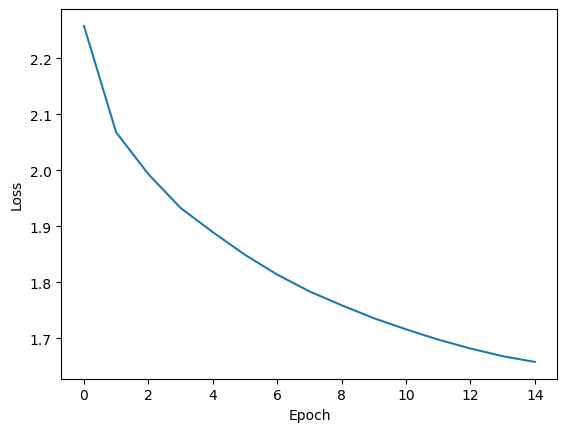

In [130]:
x = torch.arange(len(global_loss))

plt.plot(x, global_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [131]:
@torch.no_grad()
def generate_names(num=20):
    for _ in range(20):
        out = []
        context = [0] * context_length # initialize with all ...
        while True:
            x = torch.tensor([[context]]).cuda()
            logits = model(x)
            probs = F.softmax(logits, dim=1)
            ix = torch.multinomial(probs, num_samples=1).item()
            context = context[1:] + [ix]
            out.append(ix)
            if ix == 0:
                break
        print(''.join(int_to_str[i] for i in out))

In [151]:
model.eval()
generate_names()

gerem.
malcia.
petten.
terus.
cattany.
aerit.
solliannya.
alexya.
lema.
eshardon.
delery.
sun.
keyona.
shade.
avianny.
thorey.
jaar.
cataleya.
taelem.
gracie.
